In [1]:
!pip install qiskit
!pip install qiskit_aer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 17.0 MB/s eta 0:00:00


# Shor's Algorithm

Shor’s algorithm has gained renown for its ability to factor integers within polynomial time. This distinction arises from the fact that the most advanced classical algorithms necessitate time frames exceeding polynomial bounds to factor the product of two prime numbers. Consequently, widely employed cryptographic protocols such as RSA hinge on the presumption that integer factorization remains impractical for sufficiently large numbers.

Within this lecture, our primary focus will be on the quantum facet of Shor’s algorithm, which is principally concerned with solving the intricate problem of period finding. It is pertinent to note that the task of integer factorization can be effectively transformed into the problem of period finding within polynomial time. Consequently, an efficient period-finding algorithm holds the potential to facilitate the efficient factorization of integers. For the present, it suffices to demonstrate that if we can accurately compute the period of the expression

&emsp;&emsp;&emsp; $a^2 \mod N$

with efficiency, we can subsequently employ this capability for efficient integer factorization.

Recognizing that period finding constitutes a significant challenge in its own right, we shall initially tackle this problem before delving into its utilization for factorization.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

## Period Finding

Take a look at the periodic function:

&emsp;&emsp;&emsp; $f(x)=a^x\mod N$

A periodic function f(x)

where **a** and **N** are positive integers , **a** is less than **N**, and they have no common factors.

The period , or order (**r**) is the smallest non-zero integer such that:

&emsp;&emsp;&emsp; $a^r \mod N=1$

Could not find period, check a < N and have no common factors.


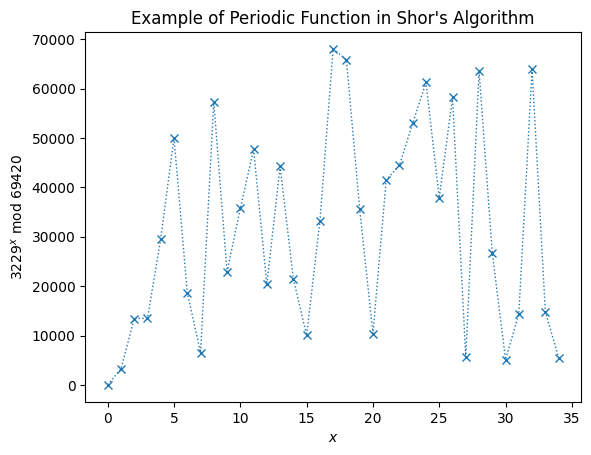

In [4]:
N = 69420
a = 3229

# Calculate the plotting data
xvals = np.arange(35)
yvals = [np.mod(a**x, N) for x in xvals]

# Use matplotlib to display it nicely
fig, ax = plt.subplots()
ax.plot(xvals, yvals, linewidth=1, linestyle='dotted', marker='x')
ax.set(xlabel='$x$', ylabel=f'${a}^x$ mod ${N}$',
       title="Example of Periodic Function in Shor's Algorithm")
try: # plot r on the graph
    r = yvals[1:].index(1) + 1
    plt.annotate('', xy=(0,1), xytext=(r,1),
                 arrowprops=dict(arrowstyle='<->'))
    plt.annotate(f'$r={r}$', xy=(r/3,1.5))
except ValueError:
    print('Could not find period, check a < N and have no common factors.')

## Let's look into this

Shor’s work was to use Quantum Phase Estimation on the unitary operator. (See other exercise)

Let’s see how this works out. If we start in the state |1> , we can see that each successive application of U will multiply the state of our register by $a (\mod N)$, and after r applications we will arrive at the state |1> again .

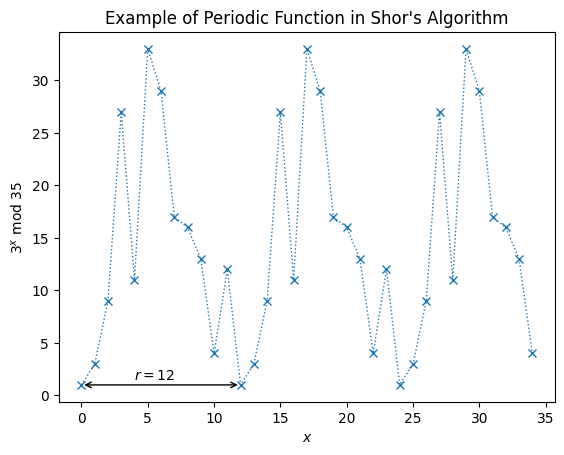

In [5]:
N = 35
a = 3

# Calculate the plotting data
xvals = np.arange(35)
yvals = [np.mod(a**x, N) for x in xvals]

# Use matplotlib to display it nicely
fig, ax = plt.subplots()
ax.plot(xvals, yvals, linewidth=1, linestyle='dotted', marker='x')
ax.set(xlabel='$x$', ylabel=f'${a}^x$ mod ${N}$',
       title="Example of Periodic Function in Shor's Algorithm")
try: # plot r on the graph
    r = yvals[1:].index(1) + 1
    plt.annotate('', xy=(0,1), xytext=(r,1),
                 arrowprops=dict(arrowstyle='<->'))
    plt.annotate(f'$r={r}$', xy=(r/3,1.5))
except ValueError:
    print('Could not find period, check a < N and have no common factors.')

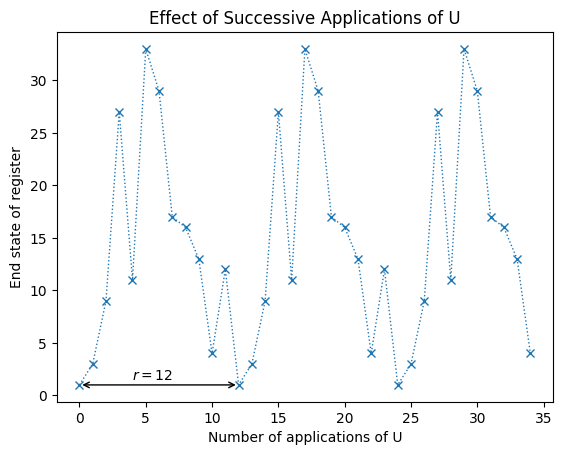

In [6]:
ax.set(xlabel='Number of applications of U',
       ylabel='End state of register',
       title="Effect of Successive Applications of U")
fig

So a superposition of the states in this cycle would be an eigenstate of U:

&emsp;&emsp;&emsp; $|u_{0}\rangle=\frac{1}{\sqrt(r)} \sum \limits _{k=0} ^{r-1}|a^k \mod N \rangle$

Let’s see this in details or a = 3 and N = 35:

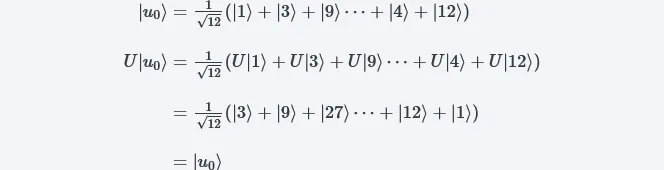

This eigenstate has an eigen value of 1. A more interesting eigenstate would be one in which phase is different for each of these computational basis states.

Can you go through and derive this?

## Using Qiskit

In [7]:
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = QuantumCircuit(4)
    for _iteration in range(power):
        if a in [2,13]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [7,8]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = f"{a}^{power} mod 15"
    c_U = U.control()
    return c_U

In [8]:
# Specify variables
N_COUNT = 8  # number of counting qubits
a = 7

In [10]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

Construct the circuit

In [11]:
# Create QuantumCircuit with N_COUNT counting qubits
# plus 4 qubits for U to act on
qc = QuantumCircuit(N_COUNT + 4, N_COUNT)

# Initialize counting qubits
# in state |+>
for q in range(N_COUNT):
    qc.h(q)

# And auxiliary register in state |1>
qc.x(N_COUNT)

# Do controlled-U operations
for q in range(N_COUNT):
    qc.append(c_amod15(a, 2**q),
             [q] + [i+N_COUNT for i in range(4)])

# Do inverse-QFT
qc.append(qft_dagger(N_COUNT), range(N_COUNT))

# Measure circuit
qc.measure(range(N_COUNT), range(N_COUNT))
qc.draw(fold=-1)  # -1 means 'do not fold'

┌───┐                                                                                                                             ┌───────┐┌─┐                     
 q_0: ┤ H ├───────■─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤0      ├┤M├─────────────────────
      ├───┤       │                                                                                                                     │       │└╥┘┌─┐                  
 q_1: ┤ H ├───────┼──────────────■──────────────────────────────────────────────────────────────────────────────────────────────────────┤1      ├─╫─┤M├──────────────────
      ├───┤       │              │                                                                                                      │       │ ║ └╥┘┌─┐               
 q_2: ┤ H ├───────┼──────────────┼──────────────■───────────────────────────────────────────────────────────────────────────────────────┤2      ├─╫──╫─┤M├───────────────
      ├───┤       │              │              │                                                                                       │       │ ║  ║ └╥┘┌─┐            
 q_3: ┤ H ├───────┼──────────────┼──────────────┼──────────────■────────────────────────────────────────────────────────────────────────┤3      ├─╫──╫──╫─┤M├────────────
      ├───┤       │              │              │              │                                                                        │  QFT† │ ║  ║  ║ └╥┘┌─┐         
 q_4: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────■─────────────────────────────────────────────────────────┤4      ├─╫──╫──╫──╫─┤M├─────────
      ├───┤       │              │              │              │              │                                                         │       │ ║  ║  ║  ║ └╥┘┌─┐      
 q_5: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────■─────────────────────────────────────────┤5      ├─╫──╫──╫──╫──╫─┤M├──────
      ├───┤       │              │              │              │              │               │                                         │       │ ║  ║  ║  ║  ║ └╥┘┌─┐   
 q_6: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────┼───────────────■─────────────────────────┤6      ├─╫──╫──╫──╫──╫──╫─┤M├───
      ├───┤       │              │              │              │              │               │               │                         │       │ ║  ║  ║  ║  ║  ║ └╥┘┌─┐
 q_7: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────┼───────────────┼────────────────■────────┤7      ├─╫──╫──╫──╫──╫──╫──╫─┤M├
      ├───┤┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐┌──────┴───────┐┌──────┴───────┐┌──────┴───────┐┌───────┴───────┐└───────┘ ║  ║  ║  ║  ║  ║  ║ └╥┘
 q_8: ┤ X ├┤0            ├┤0            ├┤0            ├┤0            ├┤0             ├┤0             ├┤0             ├┤0              ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
      └───┘│             ││             ││             ││             ││              ││              ││              ││               │          ║  ║  ║  ║  ║  ║  ║  ║ 
 q_9: ─────┤1            ├┤1            ├┤1            ├┤1            ├┤1             ├┤1             ├┤1             ├┤1              ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
           │  7^1 mod 15 ││  7^2 mod 15 ││  7^4 mod 15 ││  7^8 mod 15 ││  7^16 mod 15 ││  7^32 mod 15 ││  7^64 mod 15 ││  7^128 mod 15 │          ║  ║  ║  ║  ║  ║  ║  ║ 
q_10: ─────┤2            ├┤2            ├┤2            ├┤2            ├┤2             ├┤2             ├┤2             ├┤2              ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
           │             ││             ││             ││             ││              ││              ││              ││               │          ║  ║  ║  ║  ║  ║  ║  ║ 
q_11: ─────┤3            ├┤3            ├┤3            ├┤3            ├┤3             ├┤3       

Results

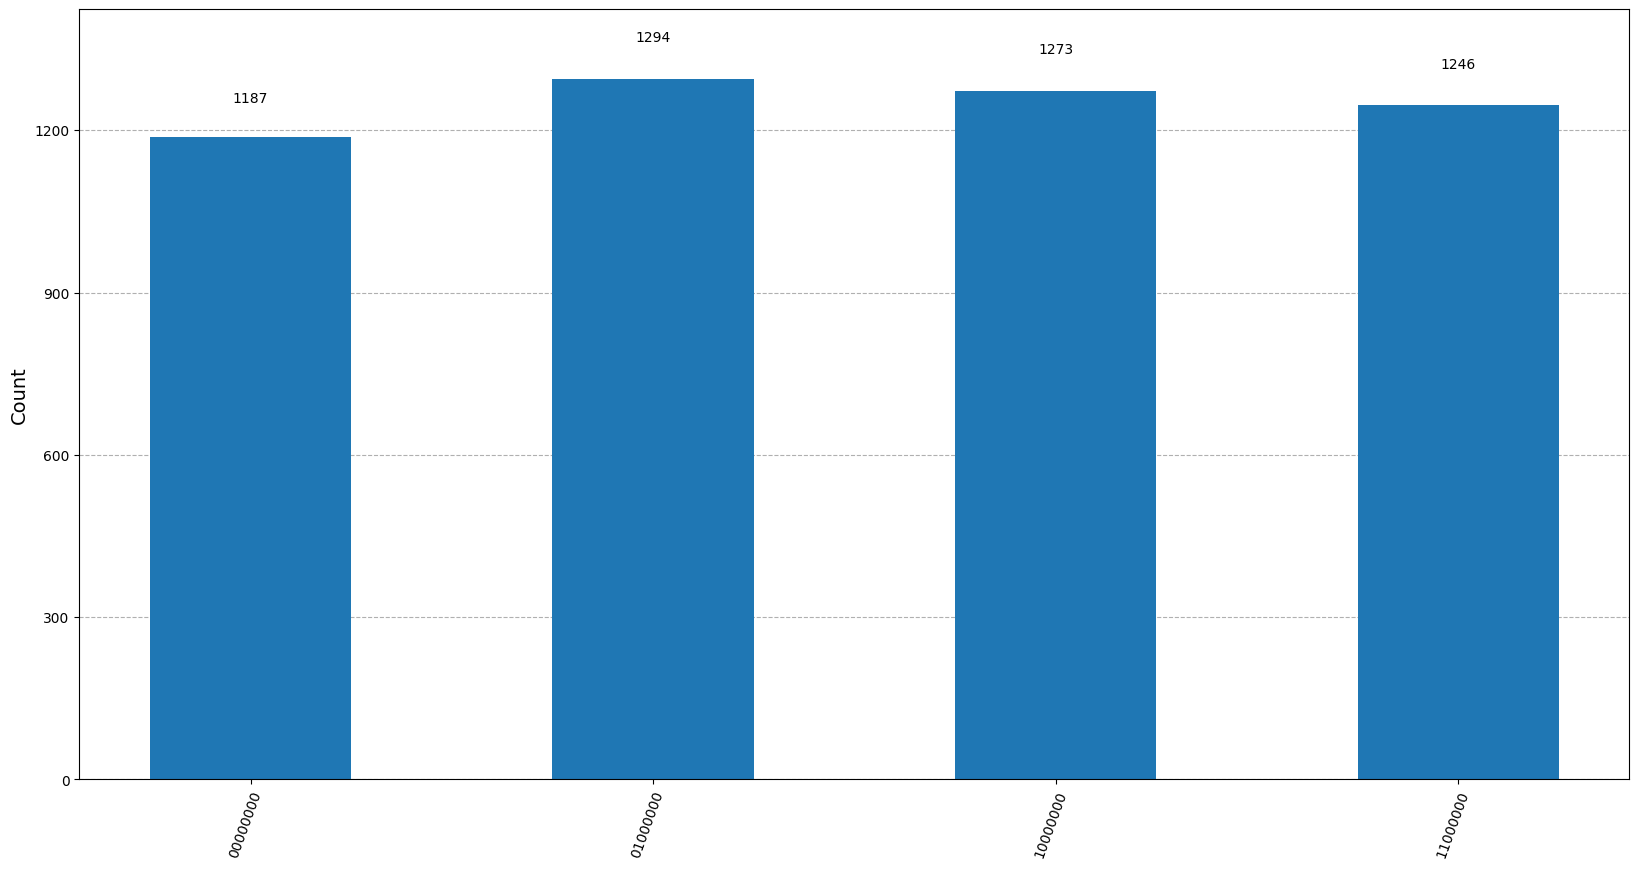

In [15]:
from qiskit_aer import AerSimulator

simulator = AerSimulator()

t_circuit = transpile(qc, simulator)
results = simulator.run(t_circuit, shots=5000).result()
counts = results.get_counts()
plot_histogram(counts, figsize = [20,10])

In [14]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**N_COUNT)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)",
                 f"{decimal}/{2**N_COUNT} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

            Register Output           Phase
0  01000000(bin) =  64(dec)   64/256 = 0.25
1  00000000(bin) =   0(dec)    0/256 = 0.00
2  11000000(bin) = 192(dec)  192/256 = 0.75
3  10000000(bin) = 128(dec)  128/256 = 0.50


We can use Fraction

In [16]:
Fraction(0.666)

Fraction(5998794703657501, 9007199254740992)

In [17]:
# Get fraction that most closely resembles 0.666
# with denominator < 15
Fraction(0.666).limit_denominator(15)

Fraction(2, 3)

The order (**r**) must be less than **N**, so we will set the maximum denominator to be 15:

In [18]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase,
                 f"{frac.numerator}/{frac.denominator}",
                 frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0   0.25      1/4            4
1   0.00      0/1            1
2   0.75      3/4            4
3   0.50      1/2            2


When running Shor's algorithm, we may encounter both correct and incorrect eigenvalues. For example, we might get a correct result with **r=4**. However, Shor's algorithm can sometimes fail.

**Why Incorrect Results Occur**
Incorrect results can happen for a few reasons:

1. **s=0**: This situation does not provide useful information.
2. **s** and **r** are not coprime: Instead of **r**, we get a factor of **r**.

**Solution**
The simplest way to handle these incorrect results is to repeat the experiment until we get a satisfactory value for **r**. This repetition increases the chances of finding the correct result.